In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from numpy import linalg as LA
from scipy.spatial import distance
from scipy.linalg import subspace_angles
from sklearn.manifold import MDS

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import plot_N, plot_FP, gen_trials_from_model_dir, name_best_ckpt, gen_X_from_model_dir

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/0/model.ckpt
Model restored from 

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log
/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/1/ckpts/model.ckpt-368000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/most/1/ckpts/model.ckpt-368000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>


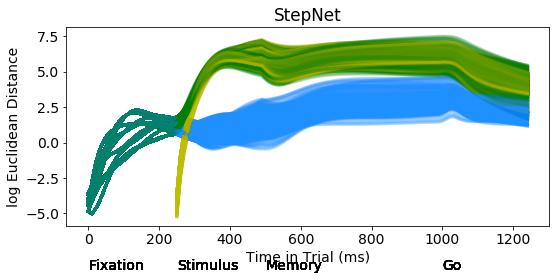

In [47]:
rule_set = ['delaygo','delayanti']

fig = plt.figure(figsize=(10, 10),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})

model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/softplus/most',str(0))
trial = gen_trials_from_model_dir(model_dir_all,rule_set[0])
trial_anti = gen_trials_from_model_dir(model_dir_all,rule_set[1])

n_stim = len(trial.stim_locs)
inds = range(n_stim)
offset = int(n_stim/2)
inds_anti = [int(j) for j in np.concatenate((inds[offset:n_stim],inds[0:offset]))]
inds_1 = [int(j) for j in np.concatenate((inds[1:n_stim],inds[0:1]))]
trial_set = range(0,400,2)

fig = plt.figure(figsize=(8, 4),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

for model_n in range(10):

    model_dir_all = os.path.join(p,'data/rnn/multitask/crystals/softplus/most',str(model_n))
    ckpt_n = name_best_ckpt(model_dir_all,'delaygo')
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    
    _, X = gen_X_from_model_dir(model_dir_all,ckpt_n_dir,trial)
    _, X_anti = gen_X_from_model_dir(model_dir_all,ckpt_n_dir,trial_anti)

    X_ga_pi = np.square(np.sum(np.power(X - X_anti[:,inds_anti,:],2),axis = 0))
    X_ga_0 = np.square(np.sum(np.power(X - X_anti,2),axis = 0))
    X_gg_pi = np.square(np.sum(np.power(X - X[:,inds_anti,:],2),axis = 0))
    X_gg_1 = np.square(np.sum(np.power(X - X[:,inds_1,:],2),axis = 0))
    
    X_ga_pi_same_mod = np.log(X_ga_pi[trial_set,:])
    X_ga_0_same_mod = np.log(X_ga_0[trial_set,:])
    X_gg_pi_same_mod = np.log(X_gg_pi[trial_set,:])
    X_gg_1_same_mod = np.log(X_gg_1[trial_set,:])
    
    plot_all_trials_simple([-10,15])
    
plt.show()

/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/lauradriscoll/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [16]:
nc = 1
max_val = 450
med_val = 5
T = 125
lw = 3
a = .5
epoch_names = ['Fixation','Stimulus','Memory','Go']
epoch_set = ['fix1','stim1','delay1','go1']
epoch_offset = -10

def plot_one_row_simple(ylim):
    c = 'dodgerblue'
    epoch_range = range(np.shape(trial.x)[0])
    plot_range = range(10*epoch_range[0],10*(epoch_range[-1]+1),10)

    plt.plot(plot_range,np.mean(X_ga_0_same_mod[:,epoch_range],axis = 0).T,'-',c = c, 
             lineWidth = lw,alpha = a,label = 'Same Stimulus, Different Movement, Different Task')

    plt.plot(plot_range,np.mean(X_ga_pi_same_mod[:,epoch_range],axis = 0).T,'-',c = 'k',
             lineWidth = lw,alpha = a,label = 'Same Movement')

    plt.plot(plot_range,np.mean(X_gg_pi_same_mod[:,epoch_range],axis = 0).T,':',c = 'k',
             lineWidth = lw,alpha = a,label = 'Same Task')
    
    plt.plot(plot_range,np.mean(X_gg_1_same_mod[:,epoch_range],axis = 0).T,'-',c = 'k',
             lineWidth = lw,alpha = 1,label = 'Same Everything')
    
    for ei in range(len(trial.epochs)):
        epoch = epoch_set[ei]
        if trial.epochs[epoch][1] is None:
            epoch_range = range(trial.epochs[epoch][0],T)
        elif trial.epochs[epoch][0] is None:
            epoch_range = range(0,trial.epochs[epoch][1])
        else:
            epoch_range = range(trial.epochs[epoch][0],trial.epochs[epoch][1])
        plt.text(10*epoch_range[0],.9*epoch_offset,epoch_names[ei])

#     plt.ylim((ylim))
    plt.legend(loc='upper left',frameon=False, fontsize = 14)
    plt.xlabel('Time in Trial (ms)')
    plt.ylabel('log Euclidean Distance')
    plt.title('StepNet')

#     plt.savefig(fldr + '/X_diff_plots_one_axis_ylim_simple' +str(ylim)+'_' + rule_set[0]+'_'+rule_set[1]+ 
#         filename + '_ckpt_'+ str(ckpt_n) + '_model_' + str(model_n) + '.svg')
#     plt.show()
    
plot_one_row_simple([-10,15])

In [46]:
nc = 1
max_val = 450
med_val = 5
T = 125
lw = 3
a = .05
epoch_names = ['Fixation','Stimulus','Memory','Go']
epoch_set = ['fix1','stim1','delay1','go1']
epoch_offset = -10

def plot_all_trials_simple(ylim):
    c = 'dodgerblue'
    d = 'darkviolet'
    epoch_range = range(np.shape(trial.x)[0])
    plot_range = range(10*epoch_range[0],10*(epoch_range[-1]+1),10)

    for t in range(0,np.shape(X_ga_0_same_mod)[0]):
        
        if t == -1:
            plt.plot(plot_range,X_ga_0_same_mod[t,epoch_range],'-',c = c, 
                     lineWidth = lw,alpha = 1,label = 'Same Stimulus, Different Movement, Different Task')

            plt.plot(plot_range,X_ga_pi_same_mod[t,epoch_range],'-',c = 'g',
                     lineWidth = lw,alpha = 1,label = 'Same Movement')

            plt.plot(plot_range,X_gg_pi_same_mod[t,epoch_range],'-',c = 'y',
                     lineWidth = lw,alpha = 1,label = 'Same Task')

#             plt.plot(plot_range,X_gg_1_same_mod[t,epoch_range],'-',c = 'k',
#                      lineWidth = lw,alpha = 1,label = 'Same Everything')
        else:
            plt.plot(plot_range,X_ga_0_same_mod[t,epoch_range],'-',c = c,lineWidth = lw,alpha = a)
            plt.plot(plot_range,X_ga_pi_same_mod[t,epoch_range],'-',c = 'g',lineWidth = lw,alpha = a)
            plt.plot(plot_range,X_gg_pi_same_mod[t,epoch_range],'-',c = 'y',lineWidth = lw,alpha = a)
#             plt.plot(plot_range,X_gg_1_same_mod[t,epoch_range],'-',c = 'k',lineWidth = lw,alpha = a)
            
    
    for ei in range(len(trial.epochs)):
        epoch = epoch_set[ei]
        if trial.epochs[epoch][1] is None:
            epoch_range = range(trial.epochs[epoch][0],T)
        elif trial.epochs[epoch][0] is None:
            epoch_range = range(0,trial.epochs[epoch][1])
        else:
            epoch_range = range(trial.epochs[epoch][0],trial.epochs[epoch][1])
        plt.text(10*epoch_range[0],.9*epoch_offset,epoch_names[ei])

    plt.legend(loc='upper left',frameon=False, fontsize = 14)
    plt.xlabel('Time in Trial (ms)')
    plt.ylabel('log Euclidean Distance')
    plt.title('StepNet')


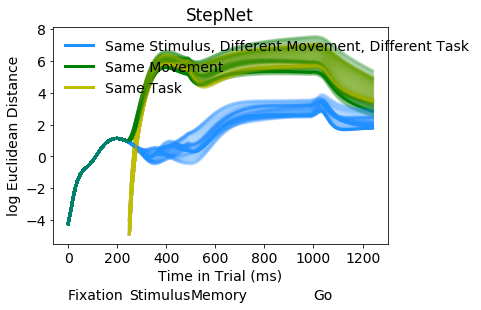

In [45]:
plot_all_trials_simple([-10,15])
plt.show()